In [1]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import sys, pathlib
repo_root = pathlib.Path('./st-celltype-deconvolution/src/models').resolve()
sys.path.insert(0, str(repo_root))

# from vae_sc import VAE, vae_loss, compute_uncertainty,compute_enhanced_uncertainty
from cvae import VAE, vae_loss, compute_uncertainty,compute_enhanced_uncertainty
from uncertainty_gcn import UncertaintyGCN, compute_loss
from gcn_claude import ImprovedUncertaintyGCN, improved_loss

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
# # 设置设备
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("使用设备:", device)

# # ================== 1. 读取数据 ==================
# scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
# ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")
# # 统一基因集并一致归一化（scRNA 与 ST 必须使用同一 gene set 和相同变换）
# genes = scRNA.var_names.intersection(ST.var_names)
# scRNA = scRNA[:, genes].copy()
# ST = ST[:, genes].copy()

# # 统一归一化策略（两端都用 total-count normalization + log1p）
# def _is_log_transformed(adata):
#     X = adata.X
#     if hasattr(X, "A"): X = X.A
#     arr = np.asarray(X)
#     if arr.size == 0:
#         return False
#     if np.nanmax(arr) > 100:
#         return False
#     return True

# for name, ad in (("scRNA", scRNA), ("ST", ST)):
#     # 先检查当前 ad.X（不要先覆盖它）
#     X_curr = ad.X.A if hasattr(ad.X, "A") else ad.X
#     print(f"{name}: current ad.X max={np.nanmax(X_curr):.4f}")
#     if _is_log_transformed(ad):
#         print(f"{name}: appears already log-transformed, skipping normalize/log1p (max={np.nanmax(X_curr):.4f})")
#         # 保留原有 ad.X，不做覆盖
#     else:
#         # 只有在 ad.X 看起来是 raw counts 时才取 counts layer 或 ad.X 做归一+log1p
#         mat = ad.layers["counts"] if "counts" in ad.layers else ad.X
#         mat = mat.A if hasattr(mat, "A") else mat
#         ad.layers["norm_counts"] = mat  # 保留原始稀疏/原始 counts
#         ad.X = ad.layers["norm_counts"]  # 现在 ad.X 是 raw counts，下面做 normalize+log1p
#         sc.pp.normalize_total(ad, target_sum=1e4)
#         sc.pp.log1p(ad)
#         print(f"{name}: applied normalize_total + log1p (new max={np.nanmax(ad.X):.4f})")

# # 现在再取 X_sc, X_st 并转成 numpy / torch
# if "counts" in scRNA.layers:
#     X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
# else:
#     X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X

# if "counts" in ST.layers:
#     X_st = ST.X.A if hasattr(ST.X, "A") else ST.X
# else:
#     X_st = ST.X.A if hasattr(ST.X, "A") else ST.X

# # 最后转 torch 并送到 device
# X_sc = torch.tensor(np.asarray(X_sc), dtype=torch.float32).to(device)
# X_st = torch.tensor(np.asarray(X_st), dtype=torch.float32).to(device)
# labels = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
# labels = torch.tensor(labels, dtype=torch.long)
# # debug 打印，强制断言维度一致
# print("genes count:", len(genes))
# print("X_sc.shape:", X_sc.shape, "X_st.shape:", X_st.shape)
# # ...existing code...

# celltypes = scRNA.obs["broad_cell_types"].astype("category").cat.categories.tolist()

In [2]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# ================== 1. 读取数据 (修改后) ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")

# 统一基因集
genes = scRNA.var_names.intersection(ST.var_names)
scRNA = scRNA[:, genes].copy()
ST = ST[:, genes].copy()
print("genes count:", len(genes))

# --- 为 ZINB-VAE 准备原始计数数据 ---
# 直接从 .layers['counts'] 中提取原始计数矩阵
# 这是将要用于训练 VAE 的数据
sc_counts_raw = scRNA.layers['counts'].A if hasattr(scRNA.layers['counts'], 'A') else scRNA.layers['counts']
X_sc_counts = torch.tensor(np.asarray(sc_counts_raw), dtype=torch.float32).to(device)


# --- 为 GCN 准备归一化+对数变换的数据 ---
# 这里的逻辑保持不变，确保 scRNA.X 和 ST.X 是归一化和log变换后的版本
def _is_log_transformed(adata):
    X = adata.X
    if hasattr(X, "A"): X = X.A
    arr = np.asarray(X)
    if arr.size == 0:
        return False
    if np.nanmax(arr) > 100:
        return False
    return True

for name, ad in (("scRNA", scRNA), ("ST", ST)):
    X_curr = ad.X.A if hasattr(ad.X, "A") else ad.X
    print(f"{name}: current ad.X max={np.nanmax(X_curr):.4f}")
    if _is_log_transformed(ad):
        print(f"{name}: appears already log-transformed, skipping normalize/log1p (max={np.nanmax(X_curr):.4f})")
    else:
        mat = ad.layers["counts"] if "counts" in ad.layers else ad.X
        mat = mat.A if hasattr(mat, "A") else mat
        ad.X = mat  # 使用原始计数进行后续处理
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        print(f"{name}: applied normalize_total + log1p (new max={np.nanmax(ad.X):.4f})")

# 从处理后的 AnnData 对象中提取归一化数据
X_sc_normalized = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
X_st_normalized = ST.X.A if hasattr(ST.X, "A") else ST.X

# 将归一化数据转为 Tensor
X_sc = torch.tensor(np.asarray(X_sc_normalized), dtype=torch.float32).to(device)
X_st = torch.tensor(np.asarray(X_st_normalized), dtype=torch.float32).to(device)

# 标签信息
labels = scRNA.obs["broad_cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)

# 打印最终形状，确认一致性
print("\n--- Final Tensor Shapes ---")
print("X_sc_counts (for VAE training):", X_sc_counts.shape)
print("X_sc (normalized, for GCN 'E' profile):", X_sc.shape)
print("X_st (normalized, for GCN input 'Y'):", X_st.shape)

celltypes = scRNA.obs["broad_cell_types"].astype("category").cat.categories.tolist()

使用设备: cuda
genes count: 1888
scRNA: current ad.X max=11.3014
scRNA: appears already log-transformed, skipping normalize/log1p (max=11.3014)
ST: current ad.X max=7.7890
ST: appears already log-transformed, skipping normalize/log1p (max=7.7890)

--- Final Tensor Shapes ---
X_sc_counts (for VAE training): torch.Size([14989, 1888])
X_sc (normalized, for GCN 'E' profile): torch.Size([14989, 1888])
X_st (normalized, for GCN input 'Y'): torch.Size([1092, 1888])


In [5]:
def train_vae_with_scheduling(vae, dataloader, num_epochs=100, device="cpu", n_conditions=None):
    """带学习率调度和早停的VAE训练"""
    vae = vae.to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )
    
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    # 逐步增加KL权重
    # beta_start, beta_end = 0.0001, 0.01
    # beta_schedule = np.linspace(beta_start, beta_end, num_epochs//2)
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_loss = 0
        
        # 设置当前beta值
        # beta = beta_end if epoch >= len(beta_schedule) else beta_schedule[epoch]
        beta = 0.001
        
        for x_batch, labels_batch in dataloader:
            x_batch = x_batch.to(device)
            labels_batch = labels_batch.to(device)
            optimizer.zero_grad()
            
            dec_mu, dec_theta, dec_pi, mu, logvar = vae(x_batch, labels_batch)
            loss, zinb, kl = vae_loss(x_batch, dec_mu, dec_theta, dec_pi, mu, logvar, beta=beta)
            
            loss.backward()
            # 梯度裁剪防止爆炸
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Beta: {beta:.6f}")
        
        # 验证并调整学习率
        scheduler.step(avg_loss)
        
        # 早停
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(vae.state_dict(), "best_vae_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    # 加载最佳模型
    vae.load_state_dict(torch.load("best_vae_model.pt"))
    return vae

In [6]:

dataset = TensorDataset(X_sc_counts, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
# 获取细胞类型数量
n_types = len(celltypes)
n_genes = X_sc_counts.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 训练VAE（使用优化的训练函数）
vae = train_vae_with_scheduling(
    vae=vae,
    dataloader=dataloader,
    num_epochs=150,  # 可根据需要调整
    device=device,
    n_conditions=n_types
)

# 计算细胞类型不确定性
# n_types = len(celltypes)
# sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
# RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
#     vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
# )

# # 归一化细胞类型不确定性作为GCN的输入
# type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
# print("细胞类型不确定性:", type_unc)

# # 可视化不确定性
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(type_unc)), type_unc)
# plt.xticks(range(len(type_unc)), celltypes, rotation=90)
# plt.title("每种细胞类型的不确定性")
# plt.tight_layout()
# plt.show()

Epoch 1/150, Loss: 0.4875, Beta: 0.001000
Epoch 11/150, Loss: 0.4187, Beta: 0.001000
Epoch 21/150, Loss: 0.4099, Beta: 0.001000
Epoch 31/150, Loss: 0.4050, Beta: 0.001000
Epoch 41/150, Loss: 0.4021, Beta: 0.001000
Epoch 51/150, Loss: 0.4010, Beta: 0.001000
Epoch 61/150, Loss: 0.3995, Beta: 0.001000
Epoch 71/150, Loss: 0.3945, Beta: 0.001000
Epoch 81/150, Loss: 0.3941, Beta: 0.001000
Epoch 91/150, Loss: 0.3945, Beta: 0.001000
Epoch 101/150, Loss: 0.3909, Beta: 0.001000
Epoch 111/150, Loss: 0.3902, Beta: 0.001000
Epoch 121/150, Loss: 0.3892, Beta: 0.001000
Epoch 131/150, Loss: 0.3879, Beta: 0.001000
Epoch 141/150, Loss: 0.3878, Beta: 0.001000


直接加载模型版

type_unc (per-type combined uncertainty): [0.04208843 0.001      0.02691438 0.20898303 0.9893248  0.33617368
 0.960423   0.26283455 0.08520252 0.8981429  0.56498975 0.6856405 ]


/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_72324/3595893421.py:60: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.

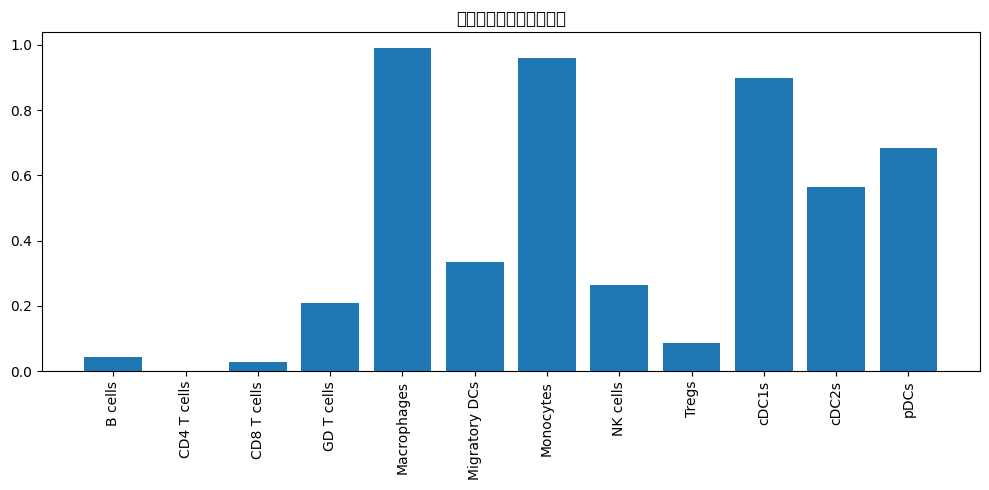

In [7]:
dataset = TensorDataset(X_sc, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
n_genes = X_sc.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 1. 加载VAE最佳模型参数
vae.load_state_dict(torch.load("best_vae_model.pt", map_location=device))
vae.eval()

# 2. 计算细胞类型不确定性（推断即可）
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)

# 3. 归一化细胞类型不确定性作为GCN的输入
# type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
# print("细胞类型不确定性:", type_unc)

def robust_normalize_per_type(x):
    # 如果全为相同值，避免除0
    if np.all(x == x[0]):
        return np.zeros_like(x, dtype=np.float32)
    q_low, q_high = np.percentile(x, [5, 95])
    return np.clip((x - q_low) / (q_high - q_low + 1e-8), 0, 1).astype(np.float32)

RE_c_norm = robust_normalize_per_type(RE_c)
KL_c_norm = robust_normalize_per_type(KL_c)
VAR_c_norm = robust_normalize_per_type(VAR_c)

# 权重可调整（参考 compute_enhanced_uncertainty 的 0.5/0.3/0.2）
w_re, w_kl, w_var = 0.5, 0.3, 0.2
combined_unc = w_re * RE_c_norm + w_kl * KL_c_norm + w_var * VAR_c_norm

# 把范围缩到 [eps, 1-eps]，并转换为 torch tensor 放到 device 上
eps = 1e-3
type_unc = combined_unc.copy()
type_unc = type_unc * (1.0 - eps) + eps
import torch
type_unc = torch.tensor(type_unc, dtype=torch.float32, device=device)

print("type_unc (per-type combined uncertainty):", type_unc.cpu().numpy())

if isinstance(type_unc, torch.Tensor):
    type_unc = type_unc.detach().cpu().numpy()
else:
    type_unc = np.asarray(type_unc)

# 4. 可视化
plt.figure(figsize=(10, 5))
plt.bar(range(len(type_unc)), type_unc)
plt.xticks(range(len(type_unc)), celltypes, rotation=90)
plt.title("每种细胞类型的不确定性")
plt.tight_layout()
plt.show()

vae训练完毕，得到细胞类型水平的不确定性

In [ ]:
# type_unc = [0]*12
# type_unc = torch.tensor(type_unc, dtype=torch.float32).to(device)

In [8]:
# --- 核心修改：使用 VAE 解码器生成细胞类型表达谱 E ---

# 假设 vae 是您已经训练好的模型
# labels 是每个单细胞对应的细胞类型编码 (torch.long tensor)
# X_sc_normalized 是归一化+对数变换后的单细胞数据
# celltypes 是细胞类型名称列表

print("Generating cell-type expression profiles using VAE decoder...")

vae.eval()  # 将 VAE 设置为评估模式
n_types = len(celltypes)
n_genes = scRNA.shape[1]

# 初始化一个空的 E_profile 矩阵
E_profile_vae = np.zeros((n_types, n_genes))

with torch.no_grad():
    # 1. 首先，用 VAE 的编码器获取所有单细胞的潜空间表示
    # 注意：这里我们仍然使用原始计数数据输入编码器，以获得最准确的潜变量
    mu, logvar = vae.encode(X_sc_counts)

    # 2. 然后，按细胞类型对这些潜空间表示进行分组，并计算每种类型的平均潜向量
    for i in range(n_types):
        # 找到属于当前细胞类型 i 的所有细胞的索引
        mask = (labels == i)
        if mask.sum() > 0:
            # 提取这些细胞的均值潜向量 mu
            latent_mu_type = mu[mask]
            
            # 计算该细胞类型的平均潜向量
            avg_latent_mu = latent_mu_type.mean(dim=0, keepdim=True)
            
            # 3. 将这个平均潜向量通过 VAE 的解码器，生成该细胞类型的“去噪”表达谱
            # 我们只关心解码出的均值 dec_mu，它代表了期望的表达水平
            dec_mu_type, _, _ = vae.decode(avg_latent_mu)
            
            # 4. 将这个表达谱存储到 E_profile 中
            E_profile_vae[i, :] = dec_mu_type.cpu().numpy()

# !!! 关键：我们需要对 VAE 生成的表达谱进行归一化和对数变换 !!!
# 因为 GCN 的重建损失是基于 log-transformed 数据的
# 创建一个临时的 AnnData 对象来方便地进行这个操作
temp_adata = sc.AnnData(E_profile_vae)
sc.pp.normalize_total(temp_adata, target_sum=1e4)
sc.pp.log1p(temp_adata)

# 这就是最终要给 GCN 使用的、由 VAE 生成的、且经过正确处理的表达谱 E
E = temp_adata.X

print("VAE-based E_profile generated and processed.")
print("E_profile shape:", E.shape)

# -------------------------------------------------------------
# 现在，您可以继续使用这个新的 E_profile 和之前计算的 type_uncertainty_from_vae
# 来训练您的 GCN 模型。
# -------------------------------------------------------------

Generating cell-type expression profiles using VAE decoder...
VAE-based E_profile generated and processed.
E_profile shape: (12, 1888)


In [ ]:
# def get_reference_profile(sc_adata, celltype_key="broad_cell_types", use_layer=None):
#     """
#     返回 shape: [n_types, n_genes] 的参考表达谱，确保使用与 ST 相同的归一化（传入的 sc_adata 应已归一化并 log1p）。
#     """
#     celltypes = sc_adata.obs[celltype_key].astype("category").cat.categories
#     expr = []
#     for ct in celltypes:
#         mask = (sc_adata.obs[celltype_key] == ct)
#         X = sc_adata[mask].X
#         X = X.A if hasattr(X, "A") else X
#         expr.append(np.asarray(X).mean(axis=0))
#     expr = np.stack(expr, axis=0)  # shape: [n_types, n_genes]
#     return expr, list(celltypes), list(sc_adata.var_names)
# E, ref_celltypes, ref_genes = get_reference_profile(scRNA, celltype_key="broad_cell_types")
# print("E.shape:", E.shape)
# assert E.shape[1] == X_st.shape[1], "参考表达谱 E 的基因数量与 ST 输入 X_st 不匹配！"

E.shape: (12, 1888)


In [10]:
# 2. 构建空间邻接关系（edge_index），假设ST_train有空间坐标
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
edges = nbrs.kneighbors_graph(coords).tocoo()
edge_index = np.vstack([edges.row, edges.col])
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

# 3. 初始化GCN模型
n_types = len(celltypes)
gcn = ImprovedUncertaintyGCN(
    in_dim=X_st.shape[1],
    hidden_dim=128,
    n_types=n_types,
    type_uncertainty=type_unc,
    dropout=0.2,
).to(device)

# 4. 训练GCN
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 500
# E = ... # 你的参考表达谱（shape: n_types, n_genes），需提前准备好

best_loss = float('inf')
patience = 30
patience_counter = 0

for epoch in range(epochs):
    gcn.train()
    optimizer.zero_grad()
    pred = gcn(X_st, edge_index)  # pred: [n_spots, n_types]
    loss, recon_loss, smooth_loss, sparsity_loss, kl_loss = improved_loss(pred[0], X_st, E, edge_index, type_unc, alpha=1.0)
    loss.backward()
    # 检查梯度是否为 0（debug）
    total_grad = 0.0
    for name, param in gcn.named_parameters():
        if param.grad is not None:
            total_grad += param.grad.abs().sum().item()
    # print(f"Epoch {epoch+1}, loss={loss.item():.4f}, total_grad={total_grad:.6f}")
    optimizer.step()

    # 保存最佳模型
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(gcn.state_dict(), "best_gcn_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0:
        print(f"\n--- Epoch {epoch} 损失项分解 ---")
        print(f"  重建损失 (原始值): {recon_loss.item():.6f}")
        print(f"  平滑损失 (原始值):     {smooth_loss.item():.6f}")
        print(f"  稀疏损失 (原始值):       {sparsity_loss.item():.6f}")
        print(f"  KL损失 (原始值):       {kl_loss.item():.6f}")
        print(f"  ------------------------------------")
        print(f"  总损失 (加权后):            {loss.item():.6f}\n")

# 训练结束后加载最佳模型
gcn.load_state_dict(torch.load("best_gcn_model.pt"))


--- Epoch 99 损失项分解 ---
  重建损失 (原始值): 1.272821
  平滑损失 (原始值):     0.001584
  稀疏损失 (原始值):       1.997666
  KL损失 (原始值):       0.401498
  ------------------------------------
  总损失 (加权后):            1.314457


--- Epoch 199 损失项分解 ---
  重建损失 (原始值): 1.271837
  平滑损失 (原始值):     0.001103
  稀疏损失 (原始值):       2.010084
  KL损失 (原始值):       0.385428
  ------------------------------------
  总损失 (加权后):            1.312313


--- Epoch 299 损失项分解 ---
  重建损失 (原始值): 1.270912
  平滑损失 (原始值):     0.001127
  稀疏损失 (原始值):       2.003353
  KL损失 (原始值):       0.393408
  ------------------------------------
  总损失 (加权后):            1.311743


--- Epoch 399 损失项分解 ---
  重建损失 (原始值): 1.270907
  平滑损失 (原始值):     0.001060
  稀疏损失 (原始值):       2.020951
  KL损失 (原始值):       0.380263
  ------------------------------------
  总损失 (加权后):            1.311190

Early stopping at epoch 434


<All keys matched successfully>

In [11]:
gcn.eval()
with torch.no_grad():
    pred = gcn(X_st, edge_index)  # [n_spots, n_types]
    pred = pred[0]

# 2. 用参考表达谱重建spot表达
E_tensor = torch.tensor(E, dtype=torch.float32, device=pred.device)  # [n_types, n_genes]
X_recon = pred @ E_tensor  # [n_spots, n_genes]

# 3. 计算R²
from sklearn.metrics import r2_score
X_true = X_st.cpu().numpy()
X_pred = X_recon.cpu().numpy()
r2 = r2_score(X_true.reshape(-1), X_pred.reshape(-1))
print(f"GCN重建表达的R²: {r2:.4f}")

GCN重建表达的R²: 0.3752


In [12]:
pred[0].sum()

tensor(1., device='cuda:0')

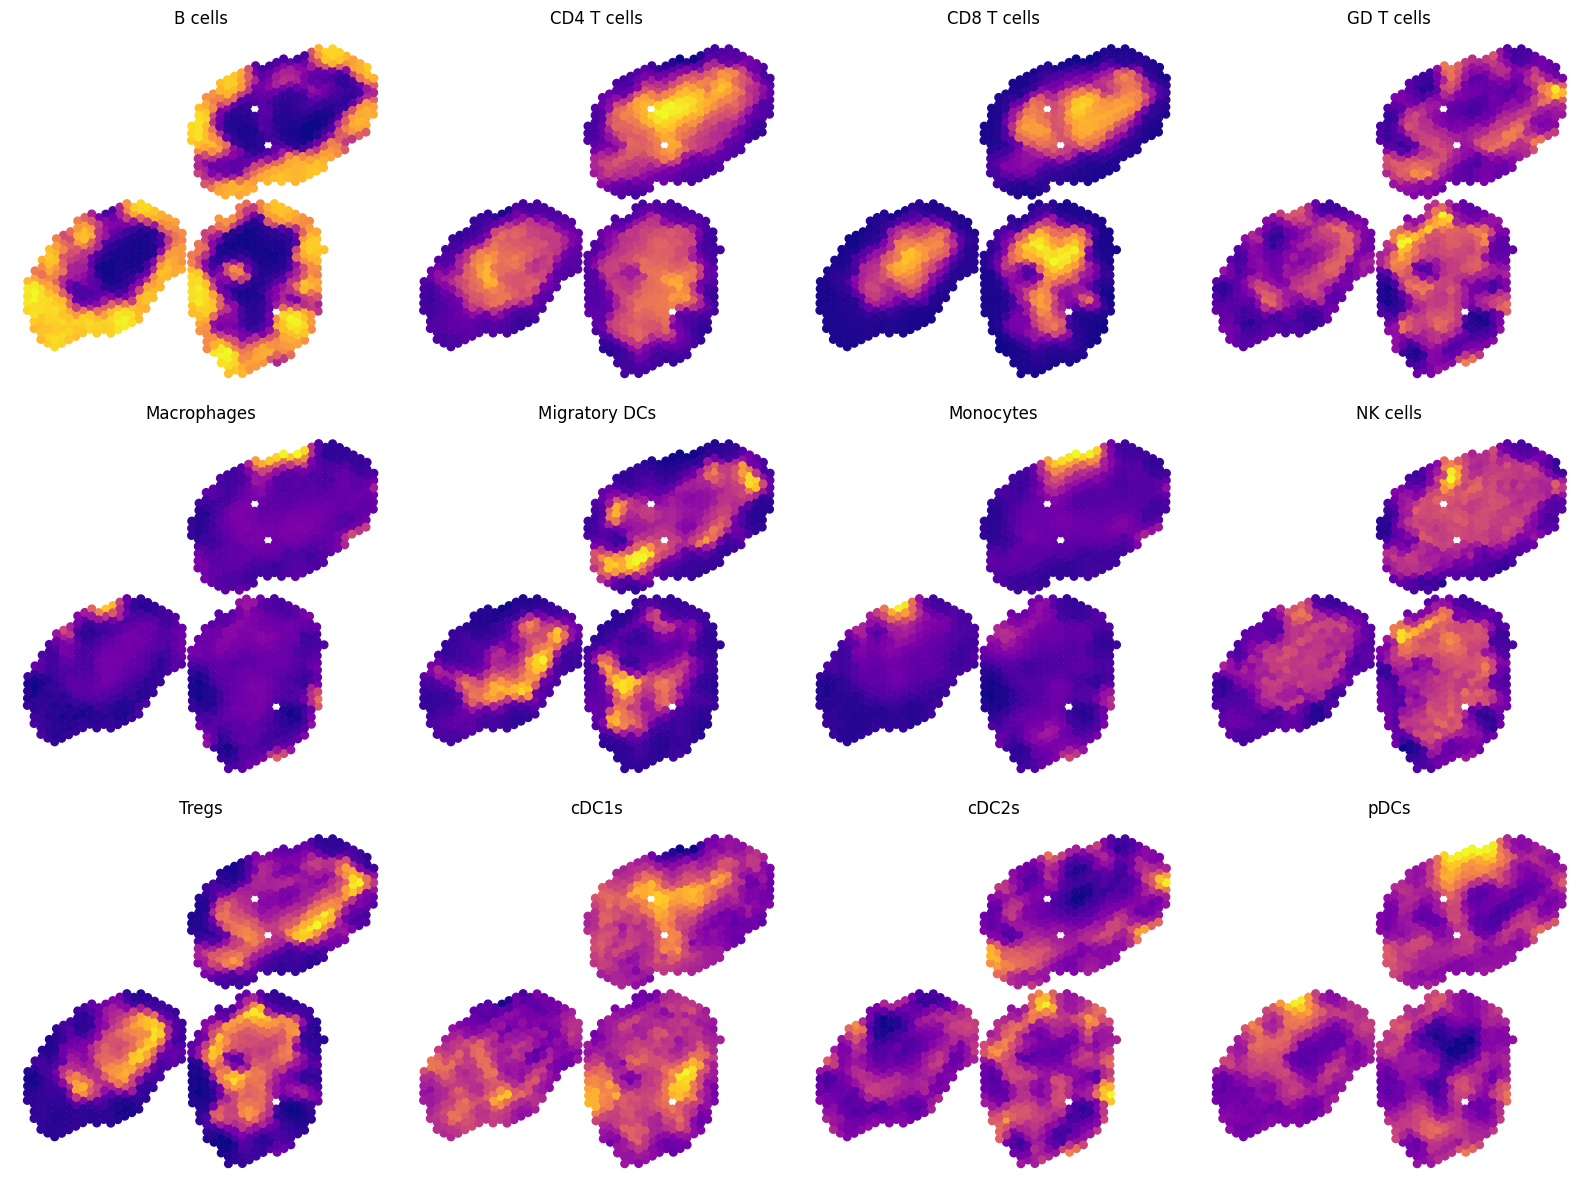

In [13]:
import math

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)
pred = pred.cpu().numpy()  # 加在 for 循环前
plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    # 交换coords的顺序，并翻转y轴
    plt.scatter(coords[:, 1], coords[:, 0], c=pred[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: Us

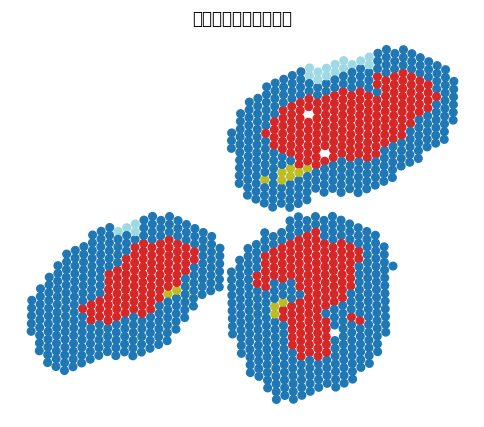

In [14]:
main_type = np.argmax(pred, axis=1)
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 1], coords[:, 0], c=main_type, s=30, cmap='tab20')
plt.title("主导细胞类型空间分布")
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# pred: [n_spots, n_types]，celltypes: 细胞类型名list
for i, ct in enumerate(celltypes):
    ST.obs[ct] = pred[:, i]

In [16]:
celltypes

['B cells',
 'CD4 T cells',
 'CD8 T cells',
 'GD T cells',
 'Macrophages',
 'Migratory DCs',
 'Monocytes',
 'NK cells',
 'Tregs',
 'cDC1s',
 'cDC2s',
 'pDCs']

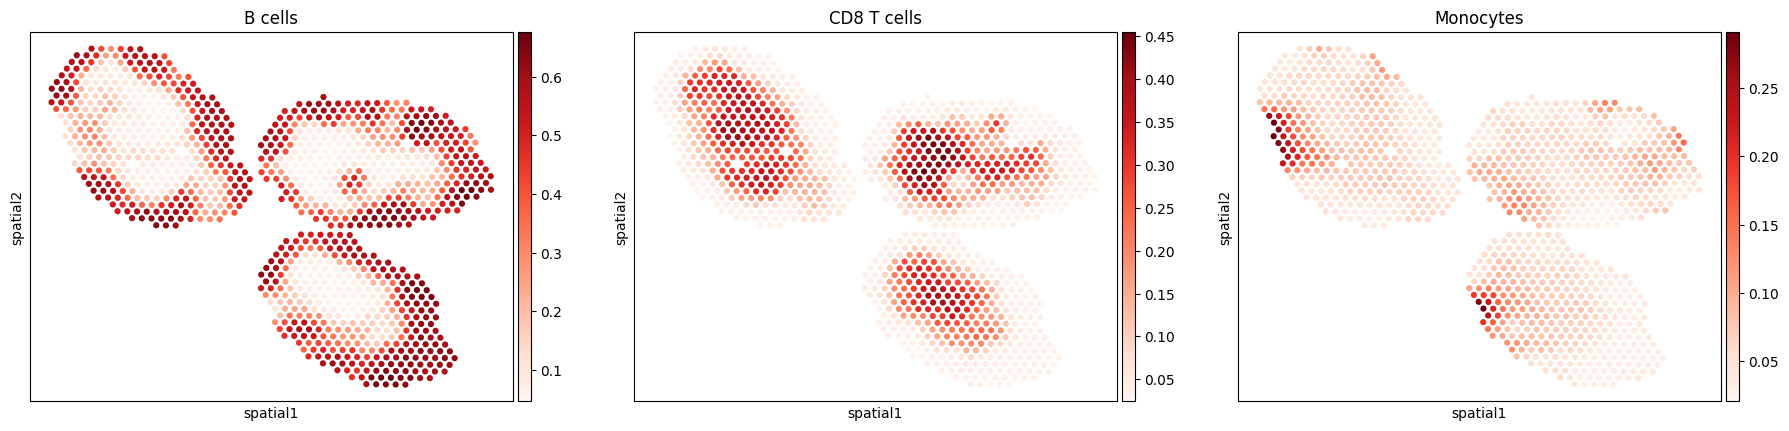

In [17]:
import scanpy as sc
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
# 如果空间坐标在 obsm["spatial"] 或 obsm["location"]，scanpy 会自动识别
sc.pl.embedding(
    ST,
    basis="spatial",  # 或 "location"，看你的 AnnData 里是哪一个
    color=ct_list,  # 画前3个细胞类型
    cmap="Reds",
    s=80
)

In [19]:
# --- 全面诊断脚本 (修正版) ---

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# 定义输出文件名
output_filename = "diagnostic_report_v2.txt"

# 假设以下变量已经准备好:
# E_profile, pred, celltypes, genes, ST

# 核心修改：更新 marker_dict 的键，使其与您的 celltypes 列表完全匹配
# 并为 T 细胞亚型添加了更具体的 Marker
marker_dict = {
    "B cells": ["MS4A1", "CD19", "CD79A"],
    "T-cell": ["CD3D", "CD3E", "CD2"], # 通用 T 细胞 Marker
    "CD4 T cells": ["CD4", "IL7R"],
    "CD8 T cells": ["CD8A", "CD8B"],
    "Monocytes": ["CD14", "CSF1R", "CCR2", "LYZ"], # 即使不在当前列表，也先保留
    "cDC1s": ["CLEC9A", "XCR1"],
    "cDC2s": ["CD1C", "SIRPA"],
    "pDCs": ["SIGLECH", "LILRA4", "IRF7"],
    "NK cells": ["NKG7", "GZMB", "KLRF1"],
    "Plasma": ["SDC1", "JCHAIN", "IGHG1"],
    "Tregs": ["FOXP3", "IL2RA"],
    # 其他在您报告中出现的类型，如果需要可以补充
    "GD T cells": ["TRDC", "TRGC1", "TRGC2"],
    "Macrophages": ["CD68", "CD163"],
    "Migratory DCs": ["CCR7", "LAMP3"]
}
# 注意：上面的基因名是大写的，这通常是人类基因的命名习惯。
# 如果您的基因列表是小鼠（首字母大写），请相应修改，例如 "MS4A1" -> "Ms4a1"

results = []

# 使用 with open() 来安全地打开和写入文件
with open(output_filename, 'w') as f:
    f.write("="*50 + "\n")
    f.write("全面诊断报告 (版本 2)\n")
    f.write("="*50 + "\n")

    for i, cell_type in enumerate(celltypes):
        f.write(f"\n--- 正在诊断: {cell_type} ---\n")
        
        # 1. VAE 表达谱诊断
        E_vec = E[i, :]
        top_20_indices = np.argsort(E_vec)[-20:]
        top_20_genes_vae = [genes[j] for j in top_20_indices]
        
        # 智能匹配 Marker，同时检查通用 T-cell 和特定 T-cell 亚型
        known_markers = marker_dict.get(cell_type, [])
        if "T cell" in cell_type: # 如果是 T 细胞亚型，也把通用的 T-cell marker 加进来
            known_markers.extend(marker_dict.get("T-cell", []))
        
        # 确保基因名的大小写能够匹配
        matched_markers_in_vae = [g for g in known_markers if g.lower() in (gene.lower() for gene in top_20_genes_vae)]
        
        f.write(f"VAE Top 20 基因: {top_20_genes_vae}\n")
        f.write(f"在 Top 20 中找到的 Marker: {matched_markers_in_vae} ({len(matched_markers_in_vae)}/{len(known_markers)})\n")

        # 2. GCN 预测结果与 Marker 基因相关性诊断
        cell_type_pred = pred[:, i]
        
        if not known_markers:
            f.write("未找到该细胞类型的已知 Marker，跳过相关性分析。\n")
            results.append({
                "Cell Type": cell_type,
                "VAE Top Markers": f"{len(matched_markers_in_vae)}/{len(known_markers)}",
                "Best Marker": "N/A",
                "Pearson r": np.nan,
                "P-value": np.nan
            })
            continue

        best_r = -np.inf
        best_p = 1
        best_marker = ""

        for marker_gene in known_markers:
            # 忽略大小写进行检查
            found_gene = next((g for g in ST.var_names if g.lower() == marker_gene.lower()), None)
            
            if found_gene is None:
                continue
                
            Xg = ST[:, found_gene].X.A.ravel() if hasattr(ST[:, found_gene].X, "A") else ST[:, found_gene].X.ravel()
            
            r, p = pearsonr(Xg, cell_type_pred)
            f.write(f"  与 {found_gene} ({marker_gene}) 的相关性: r={r:.3f}, p={p:.2e}\n")
            
            if r > best_r:
                best_r = r
                best_p = p
                best_marker = found_gene
        
        results.append({
            "Cell Type": cell_type,
            "VAE Top Markers": f"{len(matched_markers_in_vae)}/{len(known_markers)}",
            "Best Marker": best_marker,
            "Pearson r": best_r,
            "P-value": best_p
        })

    # 将最终的总结表格也写入文件
    f.write("\n\n" + "="*50 + "\n")
    f.write("诊断总结报告\n")
    f.write("="*50 + "\n")
    results_df = pd.DataFrame(results)
    f.write(results_df.to_string())

print(f"诊断报告已成功保存到文件: {output_filename}")

诊断报告已成功保存到文件: diagnostic_report_v2.txt


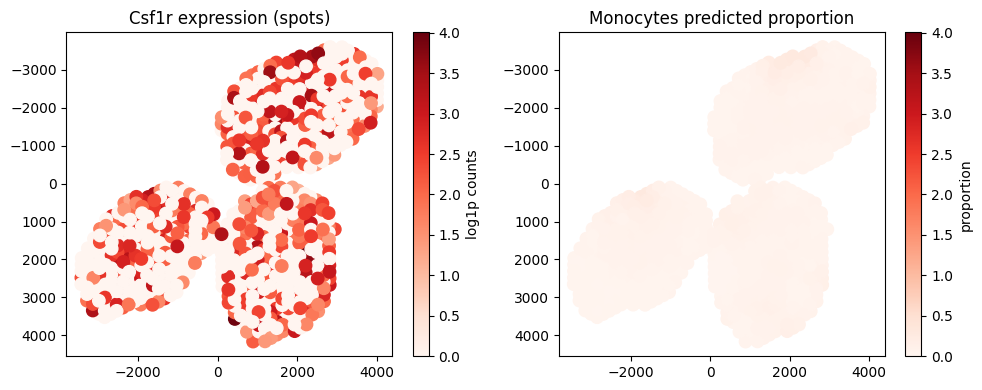

Pearson r between Csf1r and Monocytes prediction: r=0.214, p=9.21e-13


In [21]:
# python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 你要看的基因名（注意大小写/命名，应与 ST.var_names 对应）
gene = "Csf1r"   # 或者用 hits 自动匹配到的名字
# monocyte 列在 pred 中的索引（或你写入 ST.obs 的列名）
mono_idx = celltypes.index("Monocytes")  # 如果 celltypes 列表含 Monocytes
mono_pred = pred[:, mono_idx]  # pred 是之前的 numpy 数组 [n_spots, n_types]

# 提取基因表达（spot-level）
Xg = ST[:, gene].X
if hasattr(Xg, "toarray"): Xg = Xg.A
Xg = np.asarray(Xg).ravel()

# 标准化/同一色标范围（可选）
vmin = min(Xg.min(), mono_pred.min())
vmax = max(Xg.max(), mono_pred.max())

# 使用较小点大小绘图（s=30 或 80 视效果），不要乘以 median_nn 的大系数
spot_s = 80

coords = ST.obsm.get("spatial")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(coords[:,1], coords[:,0], c=Xg, s=spot_s, cmap="Reds", vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title(f"{gene} expression (spots)")
plt.colorbar(label="log1p counts")

plt.subplot(1,2,2)
plt.scatter(coords[:,1], coords[:,0], c=mono_pred, s=spot_s, cmap="Reds", vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title("Monocytes predicted proportion")
plt.colorbar(label="proportion")

plt.tight_layout()
plt.show()

# 计算相关性
r, p = pearsonr(Xg, mono_pred)
print(f"Pearson r between {gene} and Monocytes prediction: r={r:.3f}, p={p:.2e}")

In [16]:
# python
# 使用之前的 scRNA（已对齐基因名）
import pandas as pd
ct_key = "broad_cell_types"
gene_name_in_sc = gene  # 若命名不同，用 ref_genes 映射后的名字

# 计算每个细胞类型的均值
df = pd.DataFrame(scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X, columns=scRNA.var_names, index=scRNA.obs_names)
mean_by_ct = df.groupby(scRNA.obs[ct_key])[gene_name_in_sc].mean().sort_values(ascending=False)
print(mean_by_ct)

broad_cell_types
Monocytes        1.184401
cDC2s            0.536064
cDC1s            0.188435
Macrophages      0.050357
pDCs             0.037204
Migratory DCs    0.033597
B cells          0.001114
CD4 T cells      0.000000
CD8 T cells      0.000000
GD T cells       0.000000
NK cells         0.000000
Tregs            0.000000
Name: Cd14, dtype: float32


In [17]:
# python
# 1) 多基因 signature（若单基因弱，用多个 marker 的平均更稳定）
markers = ["CD14","CD68","LYZ","S100A8","S100A9","FCGR3A"]
# 与 ST.var_names 对齐（不区分大小写）
vn = list(ST.var_names)
m_present = [g for g in markers if g in vn or g.capitalize() in vn or g.upper() in vn]
# 尝试大小写变体
m_present = list({next((x for x in (g,g.capitalize(),g.upper()) if x in vn), None):None for g in markers}.keys())
m_present = [m for m in m_present if m is not None]
print("markers used:", m_present)
if m_present:
    Xm = ST[:, m_present].X
    if hasattr(Xm, "toarray"): Xm = Xm.A
    sig = Xm.mean(axis=1)   # signature = 各 marker 的均值
else:
    sig = None

markers used: ['Cd14', 'Cd68']


Pearson r (已有): 0.05516138638355432
Spearman: SpearmanrResult(correlation=0.07988336727184249, pvalue=0.008266713346015142)


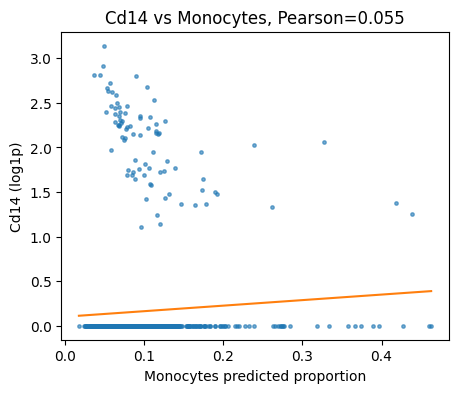

In [52]:
# python
# 2) 计算 Spearman（对非线性/稀疏更稳健）并画散点 + 线性拟合
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
gene = "Cd14"
Xg = ST[:, gene].X
if hasattr(Xg, "toarray"): Xg = Xg.A
Xg = Xg.ravel()
mono_pred = pred[:, celltypes.index("Monocytes")]  # numpy array
print("Pearson r (已有):", np.corrcoef(Xg, mono_pred)[0,1])
print("Spearman:", spearmanr(Xg, mono_pred))
# 散点图 + 回归线
slope, intercept, r, p, se = linregress(mono_pred, Xg)
plt.figure(figsize=(5,4))
plt.scatter(mono_pred, Xg, s=6, alpha=0.6)
xs = np.linspace(mono_pred.min(), mono_pred.max(), 100)
plt.plot(xs, slope*xs+intercept, color='C1')
plt.xlabel("Monocytes predicted proportion")
plt.ylabel(f"{gene} (log1p)")
plt.title(f"{gene} vs Monocytes, Pearson={np.corrcoef(Xg,mono_pred)[0,1]:.3f}")
plt.show()

In [53]:
# python
# 3) 用参考表达 E 重建该基因的预测表达（pred @ E），比较与真实表达
# 需要 ref_genes (get_reference_profile 返回的 ref_genes) 与 E 已存在
try:
    gi = ref_genes.index(gene)  # 若名字对不上会抛异常
    pred_gene = pred @ E[:, gi]   # pred 是 [n_spots, n_types]，E [n_types, n_genes]
    from scipy.stats import pearsonr
    print("corr(real, pred_reconstructed):", pearsonr(Xg, pred_gene)[0])
except Exception as e:
    print("无法用 ref_genes 定位该基因：", e)

corr(real, pred_reconstructed): 0.055054200378082827


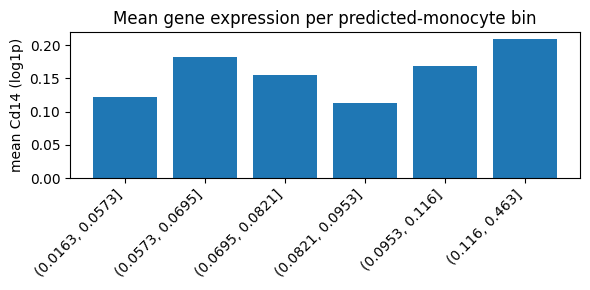

In [55]:
# python
# 4) 分箱分析（把 spots 按预测 monocyte 比例分箱，查看平均 Cd14 表达）
import pandas as pd
df = pd.DataFrame({'Xg':Xg, 'mono':mono_pred})
df['bin'] = pd.qcut(df['mono'], 6, duplicates='drop')
b = df.groupby('bin')['Xg'].mean()
# python
import matplotlib.pyplot as plt
labels = b.index.astype(str)  # 分箱标签
values = b.values
plt.figure(figsize=(6,3))
plt.bar(range(len(values)), values, color='C0')
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
plt.ylabel(f"mean {gene} (log1p)")
plt.title("Mean gene expression per predicted-monocyte bin")
plt.tight_layout()
plt.show()

In [49]:
# python
# 在 notebook 新 cell 里运行（不修改其他文件）
import numpy as np, torch
from sklearn.metrics import r2_score

def short_train_gcn(type_unc, epochs=60, lr=1e-3):
    g = ImprovedUncertaintyGCN(in_dim=X_st.shape[1], hidden_dim=128, n_types=len(celltypes),
                              type_uncertainty=type_unc, dropout=0.2).to(device)
    opt = torch.optim.Adam(g.parameters(), lr=lr, weight_decay=1e-5)
    for ep in range(epochs):
        g.train()
        opt.zero_grad()
        out = g(X_st, edge_index)
        p = out[0] if isinstance(out,(tuple,list)) else out
        loss_all = improved_loss(p, X_st, E, edge_index, type_unc)
        loss = loss_all[0] if isinstance(loss_all,(tuple,list)) else loss_all
        loss.backward()
        opt.step()
    g.eval()
    with torch.no_grad():
        out = g(X_st, edge_index)
        p = (out[0] if isinstance(out,(tuple,list)) else out).cpu().numpy()
    return g, p

# 训练三版（用短 epoch）
g_none, p_none = short_train_gcn(np.zeros(len(celltypes)), epochs=60)
g_zeros, p_zeros = short_train_gcn(np.zeros(len(celltypes)), epochs=60)
real_unc = type_unc.cpu().numpy() if torch.is_tensor(type_unc) else type_unc
real_unc = real_unc * 100
g_real, p_real = short_train_gcn(real_unc, epochs=60)

def recon_r2(p):
    Xrec = p @ np.asarray(E)
    return r2_score(X_st.cpu().numpy().reshape(-1), Xrec.reshape(-1))

print("R2 none:", recon_r2(p_none))
print("R2 zeros:", recon_r2(p_zeros))
print("R2 real:", recon_r2(p_real))
print("mean abs diff none-zeros:", np.abs(p_none-p_zeros).mean())
print("mean abs diff none-real:", np.abs(p_none-p_real).mean())

R2 none: 0.38245335630433874
R2 zeros: 0.38324473136509773
R2 real: 0.3643918247566251
mean abs diff none-zeros: 0.008932754
mean abs diff none-real: 0.04037838


In [47]:
# 检查 type_unc
import numpy as np, torch
if torch.is_tensor(type_unc):
    tnp = type_unc.detach().cpu().numpy()
else:
    tnp = np.asarray(type_unc)
print("type_unc shape, dtype, min, max, mean:", tnp.shape, tnp.dtype, tnp.min(), tnp.max(), tnp.mean())
print("unique values (up to 20):", np.unique(np.round(tnp,6))[:20])

type_unc shape, dtype, min, max, mean: (12,) float32 0.003482412 0.94629747 0.3679433
unique values (up to 20): [0.003482 0.016227 0.069827 0.178313 0.187621 0.278309 0.286627 0.358205
 0.45231  0.717307 0.920794 0.946297]
